## Intro
### A Principled Bayesian Workflow

Among his other work, [Michael Betancourt](https://betanalpha.github.io/) has a fantastically clear exposition on how a Bayesian might approach a modeling problem -- “[Towards a Principled Bayesian Workflow](https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html)”. Even if you don’t use Bayesian inference, this article contains a useful and thoughtful framework to think about whether the model you’re using to tackle a problem is good enough. It discusses more than the typical "Data Science 101" recipe  of creating a training/test/validation set, `from sklearn import ...`, cross-validation, etc. While those are essential, the framework rests on instead four foundational questions to be answered in a modeling exercise:

> Question One... Is our model consistent with our domain expertise?

> Models built upon assumptions that conflict with our domain expertise will give rise to inferences and predictions that also conflict with our domain expertise. While we don't need our model to capture every last detail of our knowledge, at the very least our models should not be in outright conflict with that knowledge.

> Question Two... Will our computational tools be sufficient to accurately fit our posteriors?

> Question Three... Will our inferences provide enough information to answer our questions?

> Question Four... Is our model rich enough to capture the relevant structure of the true data generating process?

Question two aside, the answers to these questions are relevant whether you are using a Bayesian approach in Stan, using the [workhorse that is XGBoost](https://www.kaggle.com/general/196542), fitting a billion parameter NLP model with PyTorch, etc. Furthermore, these questions are more than academic exercises -- answering these questions can help us catch failure modes as well as quantify the business impact of our models.

### What does this have to do with RNA-Seq?
RNA-Seq and other assays based on high-throughput sequencing (HTS) data are powerful tools for interrogating biological systems: from characterizing gene expression to the [3-dimensional structure of the genome](https://pubmed.ncbi.nlm.nih.gov/22652625/). While powerful, studies that leverage HTS data often suffer the following fates: 

1. HTS data will often reflect the [experimental conditions](https://www.nature.com/articles/nrg2825?proof=t) (e.g. library preparation) or [artifacts](https://genomemedicine.biomedcentral.com/articles/10.1186/gm208) (e.g. GC-bias) as much as the biological condition (e.g. treatment versus control).

2. While HTS data gives us data on many loci, we often have far fewer samples -- reducing our ability to identify differences between biological conditions.

For both cases, it is paramount to develop an expressive model that captures aspects of the data you as a modeler  think are important and understand how well it recapitulates those features. This is where the Bayesian workflow described above comes in. We can adapt it for the purposes of analyzing RNA-seq data (let's limit ourselves to differential gene expression analysis):

1. Is our model consistent with known features of RNA-seq data (e.g. variation in read depth across genes) as well as the design of the experiment?

2. (Verbatim) Will our computational tools be sufficient to accurately fit our posteriors?

3. Will our inferences provide enough information to identify genes (pathways?) differentially expressed between conditions?

4. 


In [1]:
import warnings
from itertools import chain

import nest_asyncio
import numpy as np
import pandas as pd
import seaborn as sns
import stan
from matplotlib import pyplot as plt
from scipy.stats import pearsonr

nest_asyncio.apply()
del nest_asyncio

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
RNASEQ_DATA_URL = "https://raw.githubusercontent.com/ucdavis-bioinformatics-training/2018-June-RNA-Seq-Workshop/master/thursday/all_counts.txt"

In [3]:
rnaseq_df = (
    pd.read_csv(RNASEQ_DATA_URL, sep="\t").
        transpose().
        astype("int64").
        reset_index().
        rename(columns={"index": "sample_id"})
)

In [4]:
rnaseq_df["cultivar"] = [s[0:1] if s.startswith("C") else s[0:2] for s in rnaseq_df["sample_id"]]
rnaseq_df["replicate"] = rnaseq_df["sample_id"].str[-1]
rnaseq_df["time"] = [s[1:-1] if s.startswith("C") else s[2:-1] for s in rnaseq_df["sample_id"]]

metadata_cols = ["sample_id", "cultivar", "replicate", "time"]
gene_cols = [col for col in rnaseq_df if not col in metadata_cols]

In [5]:
print(rnaseq_df.shape)
rnaseq_df.iloc[0:5,][metadata_cols + gene_cols[0:5]]

(24, 34266)


,sample_id,cultivar,replicate,time,AT1G01010,AT1G01020,AT1G03987,AT1G01030,AT1G01040
0,C61,C,1,6,289,127,0,17,605
1,C62,C,2,6,317,78,0,25,415
2,C63,C,3,6,225,142,0,32,506
3,C64,C,4,6,343,130,0,24,565
4,C91,C,1,9,325,156,0,22,762


### Probing with our Domain Expertise
What are somethings we think should be true? Do they hold?

#### Reads depth will vary across samples and on a per gene basis
* Due to library prep differences some samples will just get higher coverage
* Due to differences in gene length, GC bias, mapping artifacts, and sheer sampling, a large chunk of genes will get 0 reads and a few genes will have very high read depth

Text(0.5, 1.0, 'Average read depth per gne')

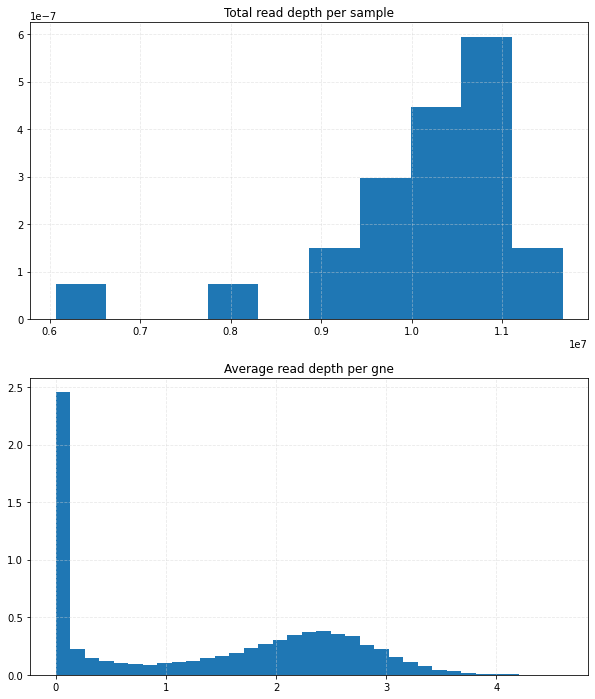

In [6]:
plt.figure(figsize=(10, 12))

plt.subplot(2, 1, 1)
plt.hist(rnaseq_df[gene_cols].sum(axis=1), density=True)
plt.grid(linestyle="--", color="lightgray", alpha=0.5)
plt.title("Total read depth per sample")

plt.subplot(2, 1, 2)
plt.hist(np.log10(1 + rnaseq_df[gene_cols]).mean(axis=0), bins=35, density=True)
plt.grid(linestyle="--", color="lightgray", alpha=0.5)
plt.title("Average read depth per gne")

#### The shape of gene-level read depth variation should be the same across samples
* Even if the total magnitude is the same, we shoulnd't expect there to be a sample-specific impact on the shape (e.g. quantiles or modes) of the distribution of read depth across genes

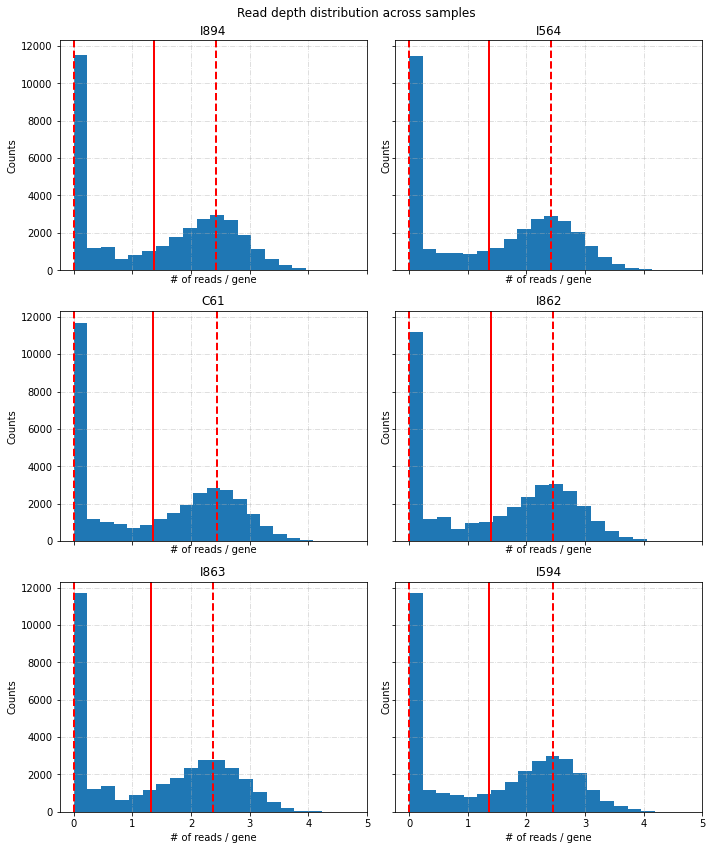

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharey=True, sharex=True)
fig.suptitle("Read depth distribution across samples")

samples_to_plot = np.random.choice(rnaseq_df["sample_id"], size=6)

for idx, ax in enumerate(chain(*axes)):
    sample = samples_to_plot[idx]
    log_read_depth = np.log10(1 + rnaseq_df.query("sample_id == @sample")[gene_cols].values.flatten())
    ax.hist(log_read_depth, density=False, bins=20)
    ax.axvline(log_read_depth.mean(), linewidth=2, color="red")
    for iqr in np.quantile(log_read_depth, [0.25, 0.75]):
        ax.axvline(iqr, linewidth=2, color="red", linestyle="--")
    ax.grid(alpha=0.5, linestyle="-.")
    ax.set_title(sample)
    ax.set_ylabel("Counts")
    ax.set_xlabel("# of reads / gene")
plt.tight_layout()

#### Technical replicates should look more similar to each other than other samples

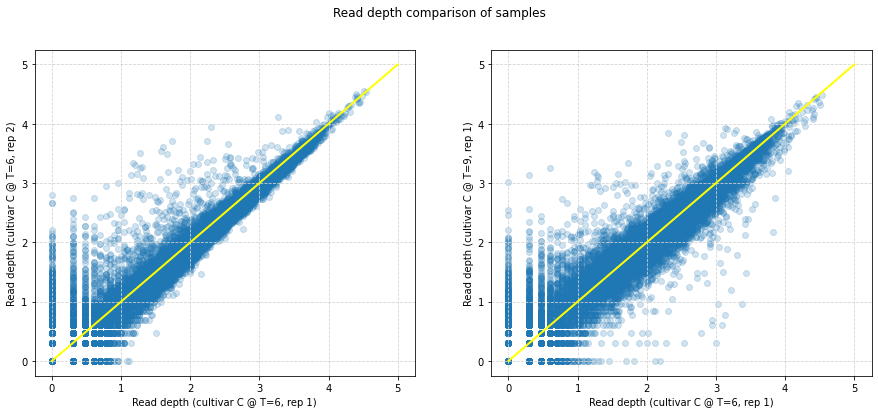

In [8]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(
    x=np.log10(1 + rnaseq_df[rnaseq_df["sample_id"] == "C61"][gene_cols].values),
    y=np.log10(1 + rnaseq_df[rnaseq_df["sample_id"] == "C62"][gene_cols].values),
    alpha=0.2
)
plt.grid(linestyle="--", color="lightgray")
plt.plot(np.linspace(0, 5, 25), np.linspace(0, 5, 25), color="yellow", linewidth=2)
plt.xlabel("Read depth (cultivar C @ T=6, rep 1)")
plt.ylabel("Read depth (cultivar C @ T=6, rep 2)")

plt.subplot(1, 2, 2)
plt.scatter(
    x=np.log10(1 + rnaseq_df[rnaseq_df["sample_id"] == "C61"][gene_cols].values),
    y=np.log10(1 + rnaseq_df[rnaseq_df["sample_id"] == "C91"][gene_cols].values),
    alpha=0.2
)
plt.grid(linestyle="--", color="lightgray")
plt.plot(np.linspace(0, 5, 25), np.linspace(0, 5, 25), color="yellow", linewidth=2)
plt.xlabel("Read depth (cultivar C @ T=6, rep 1)")
plt.ylabel("Read depth (cultivar C @ T=9, rep 1)")

plt.suptitle("Read depth comparison of samples");

#### Mean versus variance of read depth will be non-linear

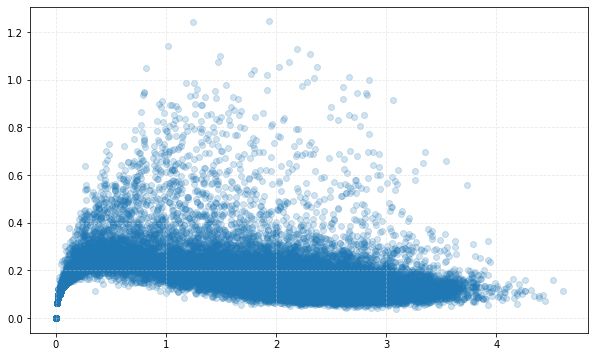

In [9]:
plt.figure(figsize=(10, 6))

plt.scatter(
    x=np.log10(1 + rnaseq_df[gene_cols]).mean(axis=0),
    y=np.log10(1 + rnaseq_df[gene_cols]).std(axis=0),
    alpha=0.2
)
plt.grid(linestyle="--", color="lightgray", alpha=0.5)

## A Basic Model
Here we introduc a basic model for the read counts observed at each gene for reach sample.
We assume that count $c_{ij}$ for sample $i$ at gene $j$ is drawn from a Poisson:

$$c_{ij} \sim Pois(\lambda)$$
$$\lambda = exp(\mu^{samp}_i + \mu^{gene}_j)$$
$$ \mu_{samp} \sim Normal(0, 5) $$
$$ \mu_{gene} \sim Normal(0, 5) $$

This model explicitly accounts for some of the features of the data generating process that we interrogated above:
* Sample-specific variation in read depth
* Gene-specific variation in read depth

Also worth noting that the motivation for the Poisson is that this distribution corresponds to the number of successes with the number of shots on goal is large but probability of success is low for each shot. This is analogous to RNA-Seq: lots of reads, but small chance that each read will align to a given gene.

In [10]:
basic_poisson_model_code = """
data {
  int<lower=0> num_genes;  // number of genes
  int<lower=0> num_samps;  // number of samples
  int<lower=0> counts[num_samps, num_genes]; // read counts
}
parameters {
  vector[num_genes] mu_gene;
  vector[num_samps] mu_samp; 
}
model {
  mu_gene ~ normal(0, 10);
  mu_samp ~ normal(0, 10);
  for(s in 1:num_samps) {
    counts[s] ~ poisson(exp(mu_samp[s] + mu_gene));
  }
}
"""

In [11]:
SUBSAMP = True
SUBSAMPSIZE = 100

cols = np.random.choice(gene_cols, SUBSAMPSIZE) if SUBSAMP else gene_cols

stan_data = {
    "num_genes": len(cols),
    "num_samps": rnaseq_df.shape[0],
    "counts": rnaseq_df[cols].values
}

## Prior Predictive Check
Instead of going right to the fitting the model, we are going to start with step 1 of seeing how well our model is with consistent with our domain expertise _i.e._ can it even generate data that captures aspects of the data that we think are important?

To do this we will start with a prior predictive check. The idea is simple:
1. Define a summary statistic that describes some germane aspect of the data
2. Draw parameters from the prior of your model
3. Simulate data from the parameters
4. Calculate the chosen summary statistic for each simulated realization of the data
5. Compare the distribution of the simulated summary statistic to the observed data

The result of the final step should be that the observed data should fall within the range of the simulated. It does not need to match as the prior did not take the data into account. But it should be at least _possible_ for the model to generate data that is similar.

In [12]:
def sample_basic_poisson_prior_pred(stat, num_genes, num_samps, num_draws=1000, **kw_args):
    mu_samp_prior = np.random.normal(loc=0, scale=5, size=(num_draws, num_samps))
    mu_gene_prior = np.random.normal(loc=0, scale=5, size=(num_draws, num_genes))
    counts_prior_pred = np.zeros((num_samps, num_genes))
    prior_pred_check = []
    
    for mu_samps, mu_genes in zip(mu_samp_prior, mu_gene_prior):
        for samp in range(num_samps):
            for gene in range(num_genes):
                mu = mu_samps[samp] + mu_genes[gene]
                counts_prior_pred[samp, gene] = np.random.poisson(lam=np.exp(mu))
        prior_pred_check.append(stat(counts_prior_pred, **kw_args))
        
    return np.array(prior_pred_check)

#### A simple, not informative check: the median of the generated data
Looks good -- low bar though! The observed data falls within the range of th prior predictive simulations.

In [13]:
median_prior_pred_check = sample_basic_poisson_prior_pred(np.median, stan_data["num_genes"], stan_data["num_samps"], axis=1)

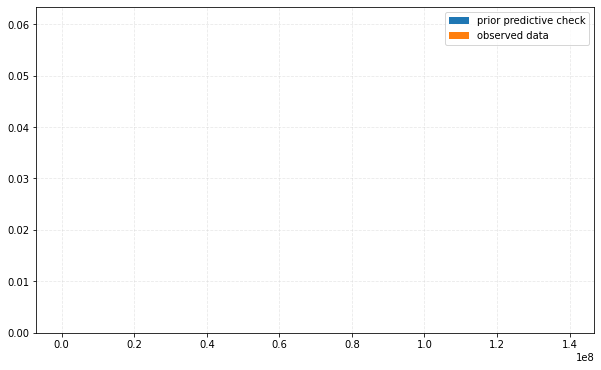

In [14]:
plt.figure(figsize=(10, 6))

plt.hist(median_prior_pred_check.flatten(), density=True, label="prior predictive check")
plt.hist(np.median(rnaseq_df[cols], axis=1), density=True, label="observed data")
plt.grid(linestyle="--", color="lightgray", alpha=0.5)
plt.legend();

#### Can we generate as many genes with 0 reads?
Again, looks good! The observed data falls within the range of th prior predictive simulations.

In [15]:
_calc_num_zeros = lambda x: (x == 0.0).sum()
calc_num_zero_genes = lambda gs: np.apply_along_axis(_calc_num_zeros, axis=0, arr=gs)

In [16]:
num_zero_genes_prior_pred_check = sample_basic_poisson_prior_pred(calc_num_zero_genes, stan_data["num_genes"], stan_data["num_samps"])

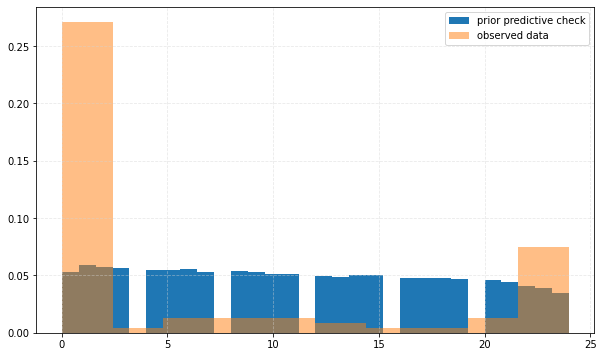

In [17]:
plt.figure(figsize=(10, 6))

plt.hist(num_zero_genes_prior_pred_check.flatten(), bins=30, density=True, label="prior predictive check")
plt.hist(calc_num_zero_genes(rnaseq_df[cols].values), density=True, alpha=0.5, label="observed data")
plt.grid(linestyle="--", color="lightgray", alpha=0.5)
plt.legend();

#### A more complicated check: the difference in pairwise correlation between replicates of the same cultivar versus random pairs of cultivars 
Failure! We see the model has a hard time generating data where the replicates within the same cultivar are more correlated with each other than random pairs -- as is the case with observed data. This should not be surprising as we did not encode this in the model! 

In [18]:
def _var_ttest_denom(v1, n1, v2, n2):
    vn1 = v1 / n1
    vn2 = v2 / n2
  
    # If df is undefined, variances are zero (assumes n1 > 0 & n2 > 0).
    # Hence it doesn't matter what df is as long as it's not NaN.
    denom = np.sqrt(vn1 + vn2)
    
    return denom

def _calc_t_stat(a, b):
    """Calculate the t statistic along the given dimension."""
    na = len(a)
    nb = len(b)
    avg_a = np.mean(a)
    avg_b = np.mean(b)
    var_a = np.var(a, ddof=1)
    var_b = np.var(b, ddof=1)
    
    denom = _var_ttest_denom(var_a, na, var_b, nb)

    return (avg_a-avg_b)/denom

def calc_pw_corr_diff(counts):
    pw_corr = np.corrcoef(counts)
    indices_1, indices_2 = np.tril_indices(n=pw_corr.shape[0], k=-1)
    pw_corr_flat = np.array([pw_corr[idx1, idx2] for idx1, idx2 in zip(indices_1, indices_2)])
    
    pw_reps = np.array([
        1 if rnaseq_df["cultivar"][idx1] == rnaseq_df["cultivar"][idx2] else 0
        for idx1, idx2 in zip(indices_1, indices_2)
    ])
    pw_corr_t = _calc_t_stat(pw_corr_flat[pw_reps == 0], pw_corr_flat[pw_reps == 1])
    
    return pw_corr_t

In [19]:
pw_corr_diff_prior_pred_check = sample_basic_poisson_prior_pred(calc_pw_corr_diff, stan_data["num_genes"], stan_data["num_samps"])

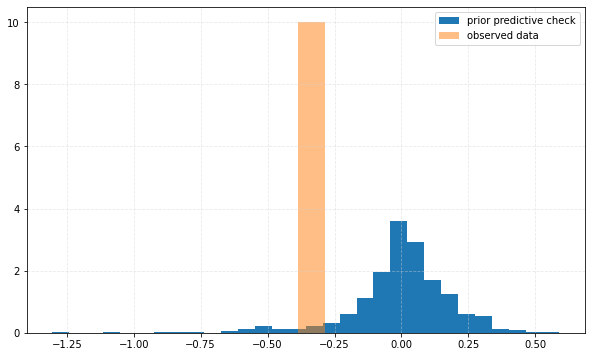

In [20]:
plt.figure(figsize=(10, 6))

plt.hist(pw_corr_diff_prior_pred_check.flatten(), bins=30, density=True, label="prior predictive check")
plt.hist(calc_pw_corr_diff(rnaseq_df[cols].values), density=True, alpha=0.5, label="observed data")
plt.grid(linestyle="--", color="lightgray", alpha=0.5)
plt.legend();

In [ ]:
basic_poisson_model = stan.build(basic_poisson_model_code, data=stan_data)

In [22]:
basic_poisson_model_fit = basic_poisson_model.sample(num_chains=1)

Sampling:   0%
Sampling:   0% (1/2000)
Sampling:   5% (100/2000)
Sampling:  10% (200/2000)
Sampling:  15% (300/2000)
Sampling:  20% (400/2000)
Sampling:  25% (500/2000)
Sampling:  30% (600/2000)
Sampling:  35% (700/2000)
Sampling:  40% (800/2000)
Sampling:  45% (900/2000)
Sampling:  50% (1000/2000)
Sampling:  50% (1001/2000)
Sampling:  55% (1100/2000)
Sampling:  60% (1200/2000)
Sampling:  65% (1300/2000)
Sampling:  70% (1400/2000)
Sampling:  75% (1500/2000)
Sampling:  80% (1600/2000)
Sampling:  85% (1700/2000)
Sampling:  90% (1800/2000)
Sampling:  95% (1900/2000)
Sampling: 100% (2000/2000)
Sampling: 100% (2000/2000), done.
Messages received during sampling:
  Gradient evaluation took 0.000687 seconds
  1000 transitions using 10 leapfrog steps per transition would take 6.87 seconds.
  Adjust your expectations accordingly!


In [23]:
coef_poisson_model_code = """
data {
  int<lower=0> num_genes;  // number of genes
  int<lower=0> num_samps;  // number of samples
  // int<lower=0> num_cultivars;  // number of cultivars
  // int<lower=0> num_times;  // number of times
  // int<lower=0> cultivars[num_samps];
  // int<lower=0> times[num_samps];
  int<lower=0> counts[num_samps, num_genes]; // read counts
}
parameters {
  vector[num_genes] mu_gene;
  vector[num_samps] mu_samp; 
  // vector[num_samps] beta_cultivar[num_cultivars];
  // real beta_time[num_times];
}
model {
  for(s in 1:num_samps) {
    counts[s] ~ poisson(exp(mu_samp[s] + mu_gene));
  }
}
"""